In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import os
import pandas as pd
from scipy.optimize import curve_fit
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table
from astropy.coordinates import EarthLocation
from astropy.time import Time
from astropy.coordinates import AltAz
from astropy.utils import iers
from astroplan import Observer, FixedTarget
from astroplan import download_IERS_A
download_IERS_A()

In [2]:
from itertools import groupby

In [3]:
wdir = "/Users/massimocapasso/Documents/BarnardCollege/CTA/SCT/Camera/"
datadir = "pSCTdata/"
logs_dir = "positioner_logs/"
plotdir = "plots/"
#os.listdir(wdir+datadir+logs_dir)

In [4]:
pointing_fname = "pointing_corrections_widget.csv"

df_corrections = pd.read_csv(wdir+pointing_fname,sep=',',
                             parse_dates=['timestamp','timestamp_pointing'],infer_datetime_format=True)
df_corrections = df_corrections.set_index(df_corrections['timestamp'])

In [5]:
run = df_corrections['run']
timestamp_current = df_corrections['timestamp']
delta_x_pix = df_corrections['delta_x_pix']
delta_y_pix = df_corrections['delta_y_pix']
timestamp_pointing = df_corrections['timestamp_pointing']
az = df_corrections['current_pos_az']
el = df_corrections['current_pos_el']

In [6]:
observing_location = EarthLocation(lat='31d40m30.4s', lon='-110d57m7.2s', height=1268*u.m)
observer = Observer(location=observing_location,name='VERITAS')
culmination_list = []
dt_culmination_list = []

for i in range(len(df_corrections)):
    t = Time(run.index[i],scale='utc')
    center = SkyCoord(az=az[i]*u.deg,alt=el[i]*u.deg,
                      frame='altaz',location=observing_location,obstime=t)
    sun_set_t = observer.sun_set_time(time=t,which='previous',horizon=0*u.deg)#horizon: default = 0 deg --> check
    culmination = observer.target_meridian_transit_time(sun_set_t,center,which='next')
    culmination_list.append(culmination.datetime64)
    dt_culmination_list.append((timestamp_current[i]-culmination.datetime64).total_seconds())

In [7]:
a_dt_culmination = np.array(dt_culmination_list)

In [8]:
"""
choose colorscale
"""
colors = cm.tab20(np.linspace(0,1,20))

In [9]:
groups = []
uniquekeys = []
len_groups = []
for k, g in groupby(run):
    group = list(g)
    groups.append(group)      # Store group iterator as a list
    len_groups.append(len(group))
    uniquekeys.append(k)

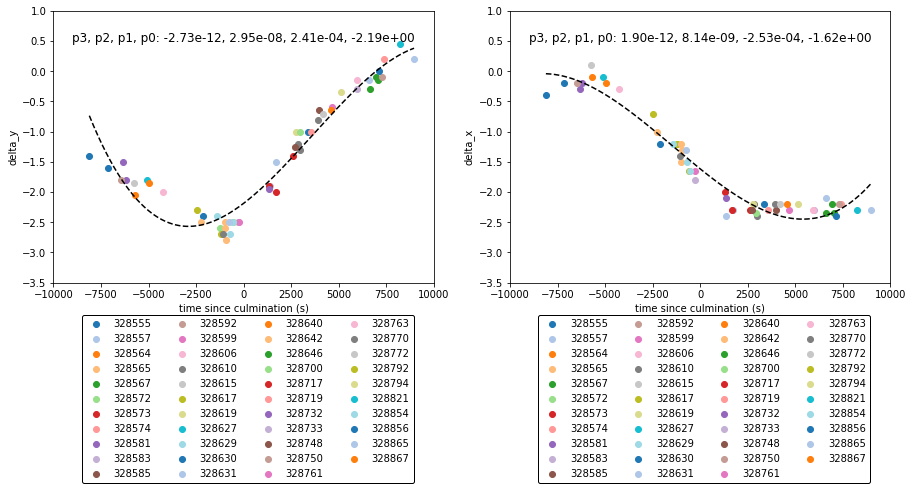

In [12]:
fig = plt.figure(figsize = (15,5))

ax0 = plt.subplot(1,2,1)
ax0.set_xlabel('time since culmination (s)')
ax0.set_ylabel('delta_y')

ax0.set_ylim(-3.5,1)
ax0.set_xlim(-10e3,10e3)

for i in range(len(groups)):
    color = colors[i%20]
    group = groups[i]
    run_num = group[0]
    pos_start = sum(len_groups[:i])
    pos_end = pos_start+len_groups[i]
    ax0.scatter(a_dt_culmination[pos_start:pos_end],delta_y_pix[pos_start:pos_end],
                label=str(run_num),color=color)#,facecolor='white')
    
    
p_y = np.polyfit(a_dt_culmination,delta_y_pix,deg=3)
ax0.text(0.5,0.9,'p3, p2, p1, p0: {0:.2e}, {1:.2e}, {2:.2e}, {3:.2e}'.format(p_y[0],p_y[1],p_y[2],p_y[3]),
         fontsize = 12, horizontalalignment='center', verticalalignment='center', 
         transform=ax0.transAxes)

x_fit = np.arange(a_dt_culmination.min(),a_dt_culmination.max())
y_fit = np.polyval(p_y,x_fit)
ax0.plot(x_fit,y_fit,'k--')

ax0.legend(fontsize='10',ncol=4,framealpha=1.,facecolor='white',edgecolor='black',bbox_to_anchor=(0.96,-0.1))

ax1 = plt.subplot(1,2,2)
ax1.set_xlabel('time since culmination (s)')
ax1.set_ylabel('delta_x')

ax1.set_ylim(-3.5,1)
ax1.set_xlim(-10e3,10e3)

for i in range(len(groups)):
    color = colors[i%20]
    group = groups[i]
    run_num = group[0]
    pos_start = sum(len_groups[:i])
    pos_end = pos_start+len_groups[i]
    ax1.scatter(a_dt_culmination[pos_start:pos_end],delta_x_pix[pos_start:pos_end],
                label=str(run_num),color=color)#,facecolor='white')
    
p_x = np.polyfit(a_dt_culmination,delta_x_pix,deg=3)
ax1.text(0.5,0.9,'p3, p2, p1, p0: {0:.2e}, {1:.2e}, {2:.2e}, {3:.2e}'.format(p_x[0],p_x[1],p_x[2],p_x[3]),
         fontsize = 12, horizontalalignment='center', verticalalignment='center', 
         transform=ax1.transAxes)

x_fit = np.arange(a_dt_culmination.min(),a_dt_culmination.max())
y_fit = np.polyval(p_x,x_fit)
ax1.plot(x_fit,y_fit,'k--')

ax1.legend(fontsize='10',ncol=4,framealpha=1.,facecolor='white',edgecolor='black',bbox_to_anchor=(0.96,-0.1))

#plt.savefig(wdir+plotdir+"delta_y_delta_x_TimeSinceCulmination_widget-all_vs_manual.png",bbox_inches='tight')